# Task 1

## Description

The goal of this task is to write code for data augmentation needed for NN training. 
Input: video, clip_duration: int, height: int, width: int
Returns: 2 augmented clips with duration clip_duration, sized height x width. 


### Import Libs

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import torch

from scipy import ndimage


### Read Video

In [2]:
video_path = "./candy_crash.mp4"


def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))


    fc = 0
    ret = True

    while (fc < frameCount  and ret):
        ret, buf[fc] = cap.read()
        fc += 1

    cap.release()
    
    return buf

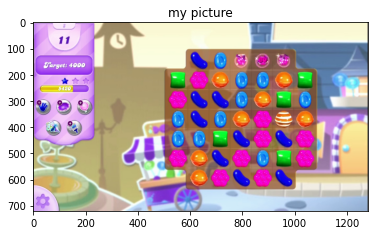

In [3]:
np_video_tensor = read_video(video_path)
plt.imshow(np_video_tensor[np_video_tensor.shape[0] // 2])
plt.title('my picture')
plt.show()

### Data Loader

In [6]:
height = 200
width = 300

In [9]:
class DataLoader():
    def __init__(self, ):
        pass
    
    def read_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))


        fc = 0
        ret = True

        while (fc < frameCount  and ret):
            ret, buf[fc] = cap.read()
            fc += 1

        cap.release()

        return buf

    def video_augmentation(self, crop_height, crop_width, video_tensor):
        sigma = [0.2, 0.4, 0.6, 0.8, 1]
        time = [0.2, 0.4, 0.6, 0.8, 1]
        
        angle_1 = [0, 90, 180, 270]
        angle_2 = [0, 90, 180, 270]
        
        
        iou_dimension = random.choice(sigma)
        iou_time = random.choice(time)
        
        angle_1_choose = random.choice(angle_1)
        angle_2_choose = random.choice(angle_2)
        
        
        video_time = video_tensor.shape[0]
        video_height = video_tensor.shape[1]
        video_width = video_tensor.shape[2]
        
        if crop_width > video_width or crop_height > video_height:
            print("Crop params larger than video origin")
            return


        height = crop_height * iou_dimension
        width = crop_width * iou_dimension
        time_crop = video_time * iou_time
        
        
        first_tensor = video_tensor[:int(time_crop),int(video_height-height):,int(video_width-width):,:]
        second_tensor = first_tensor.copy()
        
        
        def rotate(inputs, x):
            return torch.from_numpy(ndimage.rotate(inputs, x, reshape=False))
        
        first_tensor = rotate(first_tensor, angle_1_choose)
        second_tensor = rotate(second_tensor, angle_2_choose)
                
        

        return (first_tensor, second_tensor)
    

In [10]:
loader = DataLoader()
video_tensor  = loader.read_video(video_path)
cropped_video = loader.video_augmentation(height, width, video_tensor)

In [14]:
print(cropped_video[0].shape)
print(cropped_video[1].shape)

torch.Size([3973, 80, 120, 3])
torch.Size([3973, 80, 120, 3])


# Task 2

## Description

The goal of this task is to write python code for custom loss calculation

Use random generated data.
Input: Anchor sample, positive sample, N negative samples. Input vectors sized (m, 1)


### Import Libs

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm

### Config

In [2]:
class Config:
    epochs=100
    device='cpu'
    

### Generate dataset

In [3]:
n_classes = 10
X, y = datasets.make_classification(n_samples=15000, n_classes=n_classes,
                           n_features=400, n_informative=8, n_redundant=0,
                           random_state=0)

### Create pytorch dataset (anchor, positive, negative)

In [4]:
class TripletDataset(Dataset):
    def __init__(self, df, y, train=True):
        self.is_train = train
        
        if self.is_train:
            self.data = df.iloc[:,:].values
            self.labels = y.iloc[:,:].values
            self.index = df.index.values
        else:
            self.data = df.iloc[:,:].values
    
    def __getitem__(self, item):
        anchor_data = self.data[item]
        
        if self.is_train:
            anchor_label = self.labels[item]
            
            positive_list = self.index[self.index!=item][np.array([self.labels[self.index!=item]==anchor_label][0]).flatten()]
            positive_item = random.choice(positive_list)
            positive = self.data[positive_item]
            
            negative_list = self.index[self.index!=item][np.array([self.labels[self.index!=item]!=anchor_label][0]).flatten()]
            negative_item = random.choice(negative_list)
            negative = self.data[negative_item]
            
            anchor_data = torch.FloatTensor(anchor_data)
            positive = torch.FloatTensor(positive)
            negative = torch.FloatTensor(negative)
            anchor_label = torch.FloatTensor(anchor_label)
            
            return anchor_data, positive, negative, anchor_label
        
        else:
            
            return anchor_data
            
    
    def __len__(self):
        return len(self.data)
    

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
df_train_x, df_train_y = pd.DataFrame(X_train),pd.DataFrame(y_train)
df_test_x, df_test_y = pd.DataFrame(X_test),pd.DataFrame(y_test)

train_dataset = TripletDataset(df_train_x, df_train_y, train=True)
test_dataset = TripletDataset(df_test_x, df_test_y, train=True)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=4)

### Custom loss

In [19]:
class CustomLoss(nn.Module):
    def __init__(self, negative_samples):
        super(CustomLoss, self).__init__()
        self.negative_samples = negative_samples
    
    def forward(self, anchor, positive, negative):
        summ = 0
        for i in range(self.negative_samples):
            summ += negative[i] * anchor
        loss = torch.log((torch.exp(positive*anchor)) / (torch.exp(positive * anchor) + summ) )
        return loss.mean()
    
    

### Neural Network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20*20, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [24]:
model = NeuralNetwork()
model = model.to(Config.device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = CustomLoss(negative_samples=5)

### Train

In [26]:
model.train()
for epoch in tqdm(range(Config.epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor, positive, negative, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):

        anchor = anchor.to(Config.device)
        positive = positive.to(Config.device)
        negative = negative.to(Config.device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, Config.epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/2400 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Task 3

Do your personal research in the area of video summarization and choose state of the art paper. High light important moments that you would like to present during our next technical interview to the Pawa team.

I would like to talk about VasNet
https://arxiv.org/pdf/1812.01969v2.pdf

 - Overview of VasNet
 - Try different types of Attentions
 - How not to overfit ?
 - Training process